In [1]:
import pandas as pd
import numpy as np
import csv
import urllib.request
import urllib
import geopandas as gpd
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import shapely.wkt
import seaborn as sns
sns.set()

%matplotlib inline

# suppress warning
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn import preprocessing
from sklearn.metrics import silhouette_score

In [3]:
#read the zip code polygon file
zipcode = gpd.read_file('ZIP_CODE_040114.shp')

In [4]:
zipcode['ZIPCODE'] = zipcode['ZIPCODE'].astype(int)

In [5]:
zipcode = zipcode.drop_duplicates(subset=["ZIPCODE"], keep='last')
zipcode.shape

(248, 13)

In [6]:
#read the combined socio-economic data (ranked)
df_combined = pd.read_csv('ML_final_nokey.csv')

In [7]:
df_combined

,ZIPCODE,Green_%age,2021_Employment_Rate,2019_Pop_3+_in_Nursery/Presch,pop15_marital_status,pop25_att_Bachelors,2021_Median_Home_Value,2021_Income,commute_rank,safety_rank
0,10001,0.011399,0.917,0.0074,0.32,0.42,0.472468,0.521412,0.927778,0.044444
1,10002,0.177066,0.884,0.0104,0.39,0.24,0.416539,0.189844,0.822222,0.355556
2,10003,0.039076,0.929,0.0079,0.28,0.44,0.676661,0.605687,0.955556,0.188889
3,10004,0.074975,0.960,0.0182,0.40,0.48,0.681547,0.880601,0.916667,0.022222
4,10005,0.002952,0.962,0.0118,0.33,0.52,0.804327,0.847911,0.972222,0.033333
...,...,...,...,...,...,...,...,...,...,...
172,11691,0.188066,0.869,0.0278,0.40,0.17,0.303052,0.250994,0.700000,0.472222
173,11692,0.150778,0.816,0.0295,0.38,0.17,0.255352,0.242189,0.083333,0.483333
174,11693,0.068311,0.901,0.0222,0.40,0.17,0.235193,0.340733,0.077778,0.408333
175,11694,0.075225,0.909,0.0230,0.48,0.25,0.393605,0.459603,0.494444,0.905556


In [8]:
df_combined = df_combined.drop(columns=['Green_%age']) #for twitter sentiment cluster, we didn't use the green percentage in each zipcode as a feature

In [9]:
df_combined

,ZIPCODE,2021_Employment_Rate,2019_Pop_3+_in_Nursery/Presch,pop15_marital_status,pop25_att_Bachelors,2021_Median_Home_Value,2021_Income,commute_rank,safety_rank
0,10001,0.917,0.0074,0.32,0.42,0.472468,0.521412,0.927778,0.044444
1,10002,0.884,0.0104,0.39,0.24,0.416539,0.189844,0.822222,0.355556
2,10003,0.929,0.0079,0.28,0.44,0.676661,0.605687,0.955556,0.188889
3,10004,0.960,0.0182,0.40,0.48,0.681547,0.880601,0.916667,0.022222
4,10005,0.962,0.0118,0.33,0.52,0.804327,0.847911,0.972222,0.033333
...,...,...,...,...,...,...,...,...,...
172,11691,0.869,0.0278,0.40,0.17,0.303052,0.250994,0.700000,0.472222
173,11692,0.816,0.0295,0.38,0.17,0.255352,0.242189,0.083333,0.483333
174,11693,0.901,0.0222,0.40,0.17,0.235193,0.340733,0.077778,0.408333
175,11694,0.909,0.0230,0.48,0.25,0.393605,0.459603,0.494444,0.905556


In [10]:
green_dist = pd.read_csv('green_ranks.csv')

In [11]:
green_dist = green_dist.drop(columns=['Unnamed: 0'])

In [12]:
df_combined = df_combined.merge(green_dist,left_on = 'ZIPCODE', right_on = 'ZIPCODE', how = 'inner')

In [13]:
df_combined

,ZIPCODE,2021_Employment_Rate,2019_Pop_3+_in_Nursery/Presch,pop15_marital_status,pop25_att_Bachelors,2021_Median_Home_Value,2021_Income,commute_rank,safety_rank,green_tweet_rank
0,10001,0.917,0.0074,0.32,0.42,0.472468,0.521412,0.927778,0.044444,0.155556
1,10002,0.884,0.0104,0.39,0.24,0.416539,0.189844,0.822222,0.355556,0.938889
2,10003,0.929,0.0079,0.28,0.44,0.676661,0.605687,0.955556,0.188889,0.650000
3,10004,0.960,0.0182,0.40,0.48,0.681547,0.880601,0.916667,0.022222,0.494444
4,10005,0.962,0.0118,0.33,0.52,0.804327,0.847911,0.972222,0.033333,0.555556
...,...,...,...,...,...,...,...,...,...,...
172,11691,0.869,0.0278,0.40,0.17,0.303052,0.250994,0.700000,0.472222,0.038889
173,11692,0.816,0.0295,0.38,0.17,0.255352,0.242189,0.083333,0.483333,0.805556
174,11693,0.901,0.0222,0.40,0.17,0.235193,0.340733,0.077778,0.408333,0.372222
175,11694,0.909,0.0230,0.48,0.25,0.393605,0.459603,0.494444,0.905556,0.366667


In [14]:
#read twitter sentiment score dataframe
happiness_score = pd.read_csv('twitter_data_with_sentiment_score_final.csv')

In [15]:
happiness_score = happiness_score[happiness_score['userId'] != 50706690]

In [16]:
happiness_score = happiness_score.drop_duplicates(subset=['tweetId'])

In [17]:
happiness_score

,Unnamed: 0,tweetUrl,date,content,tweetId,userId,mentionedUsers,coordinates,lat,long,text,scores,final_score,geometry,index_right,ZIPCODE
1,86,https://twitter.com/ArtCommunityIns/status/135...,2021-01-31 23:50:50+00:00,Just posted a video @ SHIN GALLERY https://t.c...,1.356027e+18,707020496,NaN,{'_type': 'snscrape.modules.twitter.Coordinate...,40.717460,-73.990460,Just posted a video @ SHIN GALLERY,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,POINT (986894.566309438 200666.6874169773),92,10002
2,461,https://twitter.com/JohnnyPrimeCC/status/13560...,2021-01-31 23:12:56+00:00,"""They gave those goggles to the right idiot.""\...",1.356018e+18,588564128,"[{'_type': 'snscrape.modules.twitter.User', 'u...",{'_type': 'snscrape.modules.twitter.Coordinate...,40.713765,-73.977401,"""They gave those goggles to the right idiot."" ...","{'neg': 0.202, 'neu': 0.798, 'pos': 0.0, 'comp...",-0.5106,POINT (990515.069833148 199321.0484323865),92,10002
3,587,https://twitter.com/RafaelRufus1968/status/135...,2021-01-31 23:03:36+00:00,#SundayDinner\n#grill boneless Pork Chops\n#av...,1.356015e+18,590243316,NaN,{'_type': 'snscrape.modules.twitter.Coordinate...,40.716319,-73.982481,#SundayDinner #grill boneless Pork Chops #avoc...,"{'neg': 0.115, 'neu': 0.885, 'pos': 0.0, 'comp...",-0.2960,POINT (989106.4937206887 200251.3278961745),92,10002
4,663,https://twitter.com/aczhang0/status/1356013080...,2021-01-31 22:54:46+00:00,Chicken Nuggets and Free Whopper via T-Mobile ...,1.356013e+18,23906978,"[{'_type': 'snscrape.modules.twitter.User', 'u...",{'_type': 'snscrape.modules.twitter.Coordinate...,40.718345,-73.986579,Chicken Nuggets and Free Whopper via T-Mobile ...,"{'neg': 0.0, 'neu': 0.784, 'pos': 0.216, 'comp...",0.5106,POINT (987970.3065458384 200989.07881516597),92,10002
5,1059,https://twitter.com/evgrieve/status/1356002612...,2021-01-31 22:13:10+00:00,@edenbrower I have to have the middle leg atta...,1.356003e+18,17598047,"[{'_type': 'snscrape.modules.twitter.User', 'u...",{'_type': 'snscrape.modules.twitter.Coordinate...,40.718971,-73.991877,I have to have the middle leg attached to any ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,POINT (986501.7112302864 201217.15136251433),92,10002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432161,1709805,https://twitter.com/iDstroy/status/14067411626...,2021-06-20 22:30:03+00:00,Just posted a photo @ D-Stroy Showoff Your Gem...,1.406741e+18,17305179,NaN,{'_type': 'snscrape.modules.twitter.Coordinate...,40.790550,-73.885117,Just posted a photo @ D-Stroy Showoff Your Gems,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,POINT (1016061.6943166651 227316.287720548),194,11370
432203,592549,https://twitter.com/SeamusCampbell/status/1360...,2021-02-13 21:34:45+00:00,"Hey @RepMTG, care to take a stab at this quest...",1.360704e+18,24999101,"[{'_type': 'snscrape.modules.twitter.User', 'u...",{'_type': 'snscrape.modules.twitter.Coordinate...,40.699028,-74.039599,"Hey , care to take a stab at this question fro...","{'neg': 0.19, 'neu': 0.65, 'pos': 0.16, 'compo...",-0.1531,POINT (973269.9071669215 193953.62020642872),109,10004
432204,1453918,https://twitter.com/alemrakic/status/139410704...,2021-05-17 01:46:35+00:00,Fake news have always existed! #migrants https...,1.394107e+18,22009483,NaN,{'_type': 'snscrape.modules.twitter.Coordinate...,40.699028,-74.039599,Fake news have always existed! #migrants,"{'neg': 0.404, 'neu': 0.596, 'pos': 0.0, 'comp...",-0.5255,POINT (973269.9071669215 193953.62020642872),109,10004
432205,1840390,https://twitter.com/_biancajean_/status/140241...,2021-06-09 00:10:08+00:00,Our ride for the evening 💁🏻‍♀️⛴ @ I'm On A Boa...,1.402418e+18,40694548,NaN,{'_type': 'snscrape.modules.twitter.Coordinate...,40.698282,-74.039548,Our ride for the evening 💁🏻‍♀️⛴ @ I'm On A Boat,"{'neg': 0.0, 'neu': 0.849, 'pos': 0.151, 'comp...",0.4939,POINT (973283.6880625435 193681.91791706154),109,10004


In [18]:
#grouping the dataframe at zip code level to calculate the mean sentiment score of each zipcode
happiness_score = happiness_score.groupby(['ZIPCODE']).agg({'final_score':'mean'}).reset_index()

In [19]:
happiness_score

,ZIPCODE,final_score
0,83,0.152841
1,10001,0.121493
2,10002,0.074820
3,10003,0.120473
4,10004,0.146814
...,...,...
184,11691,0.265002
185,11692,0.051664
186,11693,0.162754
187,11694,0.125282


In [20]:
#combine the sentiment score with socio-economic data
df_combined = df_combined.merge(happiness_score,left_on = 'ZIPCODE', right_on = 'ZIPCODE', how = 'inner')

In [21]:
df_combined

,ZIPCODE,2021_Employment_Rate,2019_Pop_3+_in_Nursery/Presch,pop15_marital_status,pop25_att_Bachelors,2021_Median_Home_Value,2021_Income,commute_rank,safety_rank,green_tweet_rank,final_score
0,10001,0.917,0.0074,0.32,0.42,0.472468,0.521412,0.927778,0.044444,0.155556,0.121493
1,10002,0.884,0.0104,0.39,0.24,0.416539,0.189844,0.822222,0.355556,0.938889,0.074820
2,10003,0.929,0.0079,0.28,0.44,0.676661,0.605687,0.955556,0.188889,0.650000,0.120473
3,10004,0.960,0.0182,0.40,0.48,0.681547,0.880601,0.916667,0.022222,0.494444,0.146814
4,10005,0.962,0.0118,0.33,0.52,0.804327,0.847911,0.972222,0.033333,0.555556,0.174724
...,...,...,...,...,...,...,...,...,...,...,...
172,11691,0.869,0.0278,0.40,0.17,0.303052,0.250994,0.700000,0.472222,0.038889,0.265002
173,11692,0.816,0.0295,0.38,0.17,0.255352,0.242189,0.083333,0.483333,0.805556,0.051664
174,11693,0.901,0.0222,0.40,0.17,0.235193,0.340733,0.077778,0.408333,0.372222,0.162754
175,11694,0.909,0.0230,0.48,0.25,0.393605,0.459603,0.494444,0.905556,0.366667,0.125282


In [22]:
#normalize the sentiment score at zip code level using min- max method to assign the maximum sentiment score as 1 and minimum as 0
df_combined['final_score'] = (df_combined['final_score'] - min(df_combined['final_score']))/(max(df_combined['final_score'])-min(df_combined['final_score']))

In [23]:
df_combined

,ZIPCODE,2021_Employment_Rate,2019_Pop_3+_in_Nursery/Presch,pop15_marital_status,pop25_att_Bachelors,2021_Median_Home_Value,2021_Income,commute_rank,safety_rank,green_tweet_rank,final_score
0,10001,0.917,0.0074,0.32,0.42,0.472468,0.521412,0.927778,0.044444,0.155556,0.625463
1,10002,0.884,0.0104,0.39,0.24,0.416539,0.189844,0.822222,0.355556,0.938889,0.561416
2,10003,0.929,0.0079,0.28,0.44,0.676661,0.605687,0.955556,0.188889,0.650000,0.624064
3,10004,0.960,0.0182,0.40,0.48,0.681547,0.880601,0.916667,0.022222,0.494444,0.660210
4,10005,0.962,0.0118,0.33,0.52,0.804327,0.847911,0.972222,0.033333,0.555556,0.698509
...,...,...,...,...,...,...,...,...,...,...,...
172,11691,0.869,0.0278,0.40,0.17,0.303052,0.250994,0.700000,0.472222,0.038889,0.822393
173,11692,0.816,0.0295,0.38,0.17,0.255352,0.242189,0.083333,0.483333,0.805556,0.529640
174,11693,0.901,0.0222,0.40,0.17,0.235193,0.340733,0.077778,0.408333,0.372222,0.682084
175,11694,0.909,0.0230,0.48,0.25,0.393605,0.459603,0.494444,0.905556,0.366667,0.630662


In [24]:
df_combined = df_combined.set_index('ZIPCODE')

In [25]:
# finding silhouette score for kmeans clustering
range_n_clusters = range(2,10)
for n_clusters in range_n_clusters: 
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels_ = km.fit_predict(df_combined)
    #finding average Silhouette scores for each clustersb
    silhouette_avg_ = silhouette_score(df_combined, cluster_labels_)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg_))

For n_clusters =2, the average silhouette_score is :0.2853874965464901
For n_clusters =3, the average silhouette_score is :0.2868889939010665
For n_clusters =4, the average silhouette_score is :0.28239585972196485
For n_clusters =5, the average silhouette_score is :0.26610828654465796
For n_clusters =6, the average silhouette_score is :0.2656595391014345
For n_clusters =7, the average silhouette_score is :0.2141616032129384
For n_clusters =8, the average silhouette_score is :0.2272622842750543
For n_clusters =9, the average silhouette_score is :0.20977363165957438


In [26]:
#fit k-mean cluster to the combined data
cluster_km = KMeans(n_clusters = 4, random_state = 324).fit(df_combined)
cluster_km.labels_ = cluster_km.predict(df_combined) #get labels

In [27]:
max(cluster_km.labels_)

3

In [28]:
#create dataframe of the cluster label and zipcode
pop_label=pd.DataFrame({'ZIPCODE':df_combined.index, 'label':cluster_km.labels_ })
pop_label.head()

,ZIPCODE,label
0,10001,0
1,10002,3
2,10003,0
3,10004,0
4,10005,0


In [29]:
pop_label['label'] = pop_label['label'].astype(str)

In [30]:
#combine the cluster label data with the combined dataframe
green_cluster = zipcode.merge(pop_label,left_on = 'ZIPCODE', right_on = 'ZIPCODE', how = 'inner')

In [31]:
green_cluster

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,label
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.252 188138.380, 1038141.936 ...",2
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.713 186926.440, 1002314.243 ...",3
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.276 183696.338, 1011373.584 ...",3
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.365 183617.613, 996522.848 18...",2
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.113 176307.496, 992042.798 17...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,10036,0,New York,23543.0,1.139511e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((989419.213 215672.088, 989967.295 21...",0
173,11414,0,Howard Beach,26148.0,6.392882e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1025670.681 184011.380, 1025872.813 ...",1
174,10310,0,Staten Island,25003.0,5.346328e+07,NY,Richmond,36,085,http://www.usps.com/,0.0,0.0,"POLYGON ((950767.507 172848.969, 950787.510 17...",1
175,11693,0,Far Rockaway,11052.0,3.497516e+06,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1028453.995 167153.410, 1027813.010 ...",2


<AxesSubplot:>

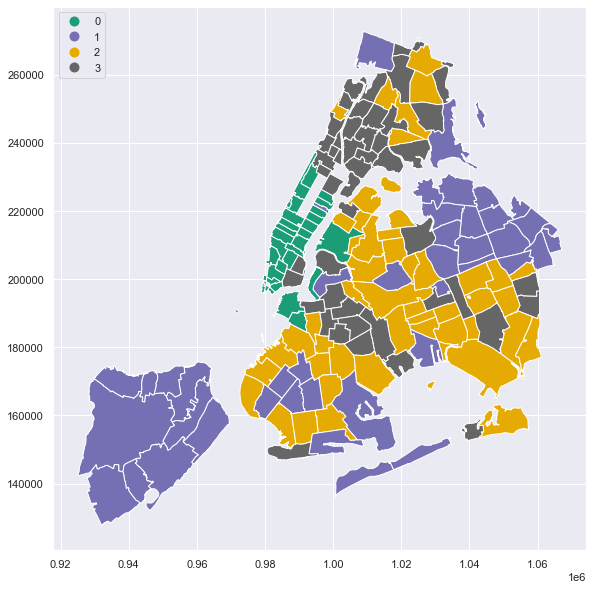

In [32]:
#visualize the clusters
fig,ax = plt.subplots(nrows=1, ncols=1,figsize=(20,10))
green_cluster.plot(column='label',cmap='Dark2', 
                                    legend=True,ax=ax, legend_kwds={'loc': 'upper left'})

In [33]:
pop_char = df_combined.reset_index()
pop_char.head()

,ZIPCODE,2021_Employment_Rate,2019_Pop_3+_in_Nursery/Presch,pop15_marital_status,pop25_att_Bachelors,2021_Median_Home_Value,2021_Income,commute_rank,safety_rank,green_tweet_rank,final_score
0,10001,0.917,0.0074,0.32,0.42,0.472468,0.521412,0.927778,0.044444,0.155556,0.625463
1,10002,0.884,0.0104,0.39,0.24,0.416539,0.189844,0.822222,0.355556,0.938889,0.561416
2,10003,0.929,0.0079,0.28,0.44,0.676661,0.605687,0.955556,0.188889,0.650000,0.624064
3,10004,0.960,0.0182,0.40,0.48,0.681547,0.880601,0.916667,0.022222,0.494444,0.660210
4,10005,0.962,0.0118,0.33,0.52,0.804327,0.847911,0.972222,0.033333,0.555556,0.698509


In [34]:
pop_char = pop_char.merge(pop_label,on='ZIPCODE')
pop_char.head()

,ZIPCODE,2021_Employment_Rate,2019_Pop_3+_in_Nursery/Presch,pop15_marital_status,pop25_att_Bachelors,2021_Median_Home_Value,2021_Income,commute_rank,safety_rank,green_tweet_rank,final_score,label
0,10001,0.917,0.0074,0.32,0.42,0.472468,0.521412,0.927778,0.044444,0.155556,0.625463,0
1,10002,0.884,0.0104,0.39,0.24,0.416539,0.189844,0.822222,0.355556,0.938889,0.561416,3
2,10003,0.929,0.0079,0.28,0.44,0.676661,0.605687,0.955556,0.188889,0.650000,0.624064,0
3,10004,0.960,0.0182,0.40,0.48,0.681547,0.880601,0.916667,0.022222,0.494444,0.660210,0
4,10005,0.962,0.0118,0.33,0.52,0.804327,0.847911,0.972222,0.033333,0.555556,0.698509,0


In [35]:
pop_char_grp = pop_char.groupby('label').mean()

In [36]:
pop_char_grp = pop_char_grp.iloc[:,1:]
# pop_char_grp.pop(-2)
pop_char_grp

,2021_Employment_Rate,2019_Pop_3+_in_Nursery/Presch,pop15_marital_status,pop25_att_Bachelors,2021_Median_Home_Value,2021_Income,commute_rank,safety_rank,green_tweet_rank,final_score
label,,,,,,,,,,
0,0.938353,0.017082,0.422059,0.399412,0.715565,0.695821,0.825654,0.205556,0.588889,0.611190
1,0.912682,0.016257,0.530227,0.234318,0.359542,0.414604,0.680682,0.832702,0.419318,0.559677
2,0.885900,0.015264,0.446600,0.210200,0.344467,0.358954,0.245556,0.600000,0.256778,0.588461
3,0.858245,0.018159,0.346327,0.190612,0.327851,0.248126,0.380726,0.342063,0.789909,0.545572


In [37]:
# pop_char_grp.rename(columns={'Green_%age':'Green Percentage'}, inplace=True)
pop_char_grp.rename(columns={'2021_Employment_Rate':'Employment Rate'}, inplace=True)
pop_char_grp.rename(columns={'2019_Pop_3+_in_Nursery/Presch':'Age 3+ Nursery Enrolled'}, inplace=True)
pop_char_grp.rename(columns={'pop15_marital_status':'Marital Status'}, inplace=True)
pop_char_grp.rename(columns={'pop25_att_Bachelors':'Age 25+ Bachelors Degree'}, inplace=True)
pop_char_grp.rename(columns={'2021_Median_Home_Value':'Median House Price'}, inplace=True)
pop_char_grp.rename(columns={'2021_Income':'Median Income'}, inplace=True)
pop_char_grp.rename(columns={'commute_rank':'Commute time to Work'}, inplace=True)
pop_char_grp.rename(columns={'safety_rank':'Safety'}, inplace=True)
pop_char_grp.rename(columns={'green_tweet_rank':'Tweet distance fro closest Green Space'}, inplace=True)
pop_char_grp.rename(columns={'final_score':'Tweet Sentiment Score'}, inplace=True)

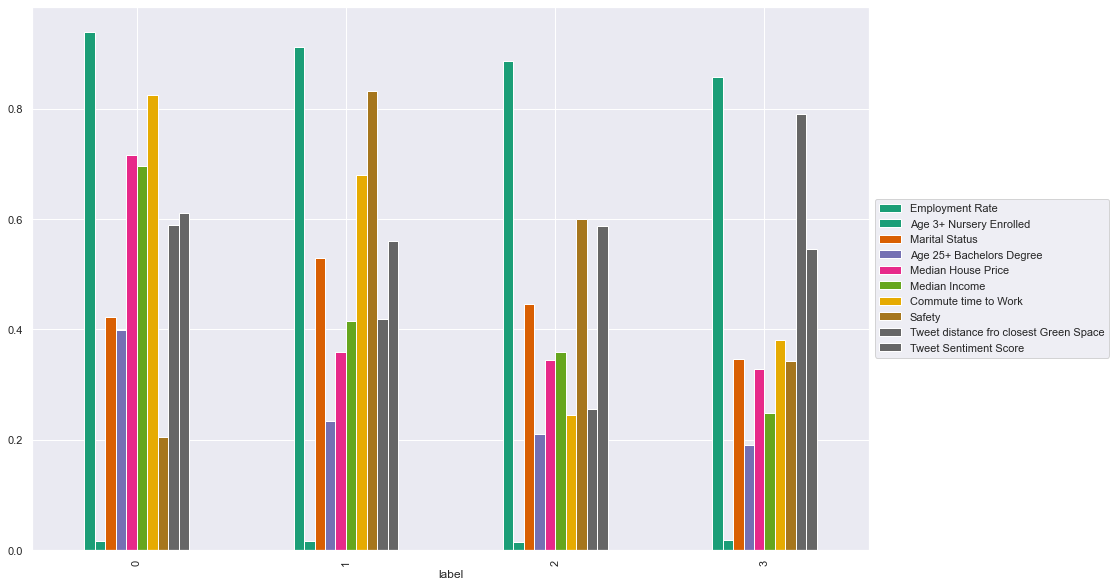

In [38]:
#bar plot of the underlying characteristics of each clusters
pop_char_grp.plot.bar(figsize = (15,10), cmap = 'Dark2')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [39]:
#finding silhouette score for Gaussian Mixture 
range_n_clusters = range(2,10)
for n_clusters in range_n_clusters: 
    gmm = GaussianMixture(n_components=n_clusters, random_state=324)
    cluster_labels_ = gmm.fit_predict(df_combined)
    #finding average Silhouette scores for each clusters
    silhouette_avg_ = silhouette_score(df_combined, cluster_labels_)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg_))

For n_clusters =2, the average silhouette_score is :0.23737323961118192
For n_clusters =3, the average silhouette_score is :0.2702730636430981
For n_clusters =4, the average silhouette_score is :0.25076466360357447
For n_clusters =5, the average silhouette_score is :0.23406420109509263
For n_clusters =6, the average silhouette_score is :0.21660764889308162
For n_clusters =7, the average silhouette_score is :0.1970730726653399
For n_clusters =8, the average silhouette_score is :0.18577870828503706
For n_clusters =9, the average silhouette_score is :0.18304833587971958


In [40]:
#fit gaussian mixture model
cluster_gmm = GaussianMixture(n_components = 4, random_state = 324).fit(df_combined)
cluster_gmm.labels_ = cluster_gmm.predict(df_combined) #get labels

In [41]:
#combine the cluster label data with the combined dataframe
pop_label=pd.DataFrame({'ZIPCODE':df_combined.index, 'label':cluster_gmm.labels_ })
pop_label.head()

,ZIPCODE,label
0,10001,3
1,10002,1
2,10003,3
3,10004,3
4,10005,3


In [42]:
pop_label['label'] = pop_label['label'].astype(str)

In [43]:
green_cluster2 = zipcode.merge(pop_label,left_on = 'ZIPCODE', right_on = 'ZIPCODE', how = 'inner')

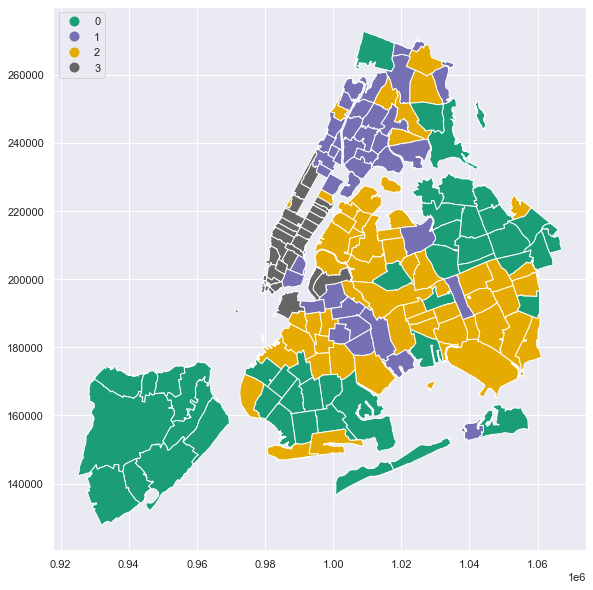

In [44]:
#visualize the clusters
fig,ax = plt.subplots(nrows=1, ncols=1,figsize=(20,10))
green_cluster2.plot(column='label',cmap='Dark2', 
                                    legend=True,ax=ax, legend_kwds={'loc': 'upper left'})
plt.savefig("With_Tweet_GMM.png", transparent = True)

In [45]:
pop_char = df_combined.reset_index()
pop_char.head()

,ZIPCODE,2021_Employment_Rate,2019_Pop_3+_in_Nursery/Presch,pop15_marital_status,pop25_att_Bachelors,2021_Median_Home_Value,2021_Income,commute_rank,safety_rank,green_tweet_rank,final_score
0,10001,0.917,0.0074,0.32,0.42,0.472468,0.521412,0.927778,0.044444,0.155556,0.625463
1,10002,0.884,0.0104,0.39,0.24,0.416539,0.189844,0.822222,0.355556,0.938889,0.561416
2,10003,0.929,0.0079,0.28,0.44,0.676661,0.605687,0.955556,0.188889,0.650000,0.624064
3,10004,0.960,0.0182,0.40,0.48,0.681547,0.880601,0.916667,0.022222,0.494444,0.660210
4,10005,0.962,0.0118,0.33,0.52,0.804327,0.847911,0.972222,0.033333,0.555556,0.698509


In [46]:
pop_char = pop_char.merge(pop_label,on='ZIPCODE')
pop_char.head()

,ZIPCODE,2021_Employment_Rate,2019_Pop_3+_in_Nursery/Presch,pop15_marital_status,pop25_att_Bachelors,2021_Median_Home_Value,2021_Income,commute_rank,safety_rank,green_tweet_rank,final_score,label
0,10001,0.917,0.0074,0.32,0.42,0.472468,0.521412,0.927778,0.044444,0.155556,0.625463,3
1,10002,0.884,0.0104,0.39,0.24,0.416539,0.189844,0.822222,0.355556,0.938889,0.561416,1
2,10003,0.929,0.0079,0.28,0.44,0.676661,0.605687,0.955556,0.188889,0.650000,0.624064,3
3,10004,0.960,0.0182,0.40,0.48,0.681547,0.880601,0.916667,0.022222,0.494444,0.660210,3
4,10005,0.962,0.0118,0.33,0.52,0.804327,0.847911,0.972222,0.033333,0.555556,0.698509,3


In [47]:
pop_char_grp = pop_char.groupby('label').mean()

In [48]:
pop_char_grp = pop_char_grp.iloc[:,1:]
pop_char_grp

,2021_Employment_Rate,2019_Pop_3+_in_Nursery/Presch,pop15_marital_status,pop25_att_Bachelors,2021_Median_Home_Value,2021_Income,commute_rank,safety_rank,green_tweet_rank,final_score
label,,,,,,,,,,
0,0.907667,0.016423,0.527083,0.219167,0.349456,0.395558,0.650463,0.808391,0.438079,0.576520
1,0.852975,0.018923,0.333250,0.177000,0.318909,0.218199,0.399167,0.312639,0.809028,0.535310
2,0.889052,0.015388,0.439138,0.233966,0.382044,0.391463,0.245690,0.560824,0.314368,0.572524
3,0.940613,0.016497,0.415484,0.405484,0.701560,0.696348,0.887634,0.211380,0.593369,0.621633


In [49]:
# pop_char_grp.rename(columns={'Green_%age':'Green Percentage'}, inplace=True)
pop_char_grp.rename(columns={'2021_Employment_Rate':'Employment Rate'}, inplace=True)
pop_char_grp.rename(columns={'2019_Pop_3+_in_Nursery/Presch':'Age 3+ Nursery Enrolled'}, inplace=True)
pop_char_grp.rename(columns={'pop15_marital_status':'Marital Status'}, inplace=True)
pop_char_grp.rename(columns={'pop25_att_Bachelors':'Age 25+ Bachelors Degree'}, inplace=True)
pop_char_grp.rename(columns={'2021_Median_Home_Value':'Median House Price'}, inplace=True)
pop_char_grp.rename(columns={'2021_Income':'Median Income'}, inplace=True)
pop_char_grp.rename(columns={'commute_rank':'Commute time to Work'}, inplace=True)
pop_char_grp.rename(columns={'safety_rank':'Safety'}, inplace=True)
pop_char_grp.rename(columns={'green_tweet_rank':'Tweet distance fro closest Green Space'}, inplace=True)
pop_char_grp.rename(columns={'final_score':'Tweet Sentiment Score'}, inplace=True)

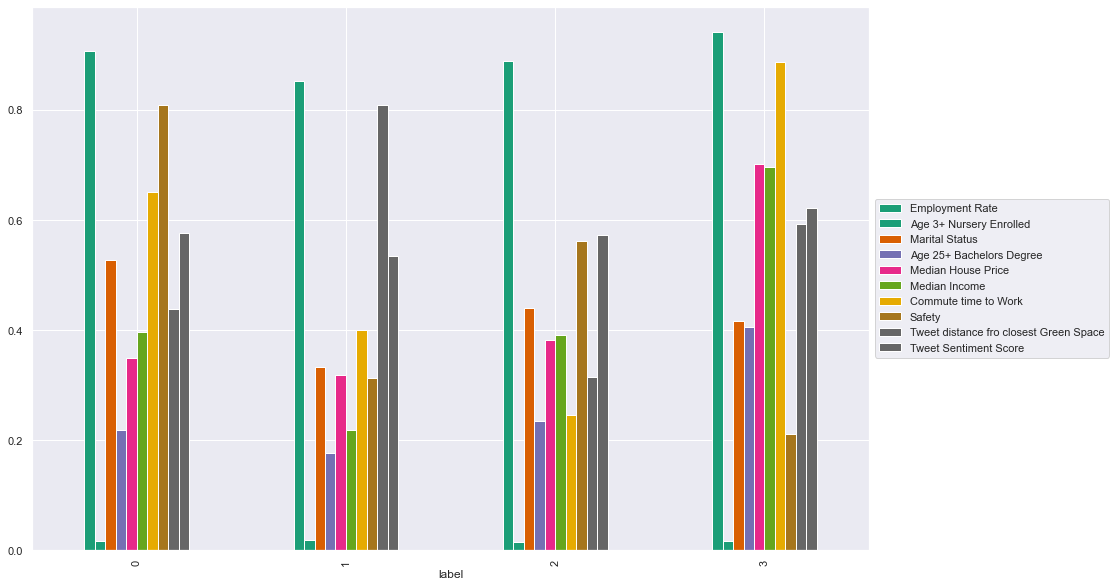

In [50]:
#bar plot of the underlying characteristics of each clusters
pop_char_grp.plot.bar(figsize = (15,10), cmap = 'Dark2')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.savefig("With_Tweet_GMM_bar.png", transparent = True)

In [51]:
#Below codes are for visualizing the spatial distribution of tweet sentiment score density along with point of interest locations

In [52]:
#the sentiment score at zipcode level
happiness_score

,ZIPCODE,final_score
0,83,0.152841
1,10001,0.121493
2,10002,0.074820
3,10003,0.120473
4,10004,0.146814
...,...,...
184,11691,0.265002
185,11692,0.051664
186,11693,0.162754
187,11694,0.125282


In [53]:
#merging with the zipcode shape file
happy_zip = zipcode.merge(happiness_score,left_on = 'ZIPCODE', right_on = 'ZIPCODE', how = 'inner')

In [54]:
happy_zip

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,final_score
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.252 188138.380, 1038141.936 ...",-0.189779
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.713 186926.440, 1002314.243 ...",0.128107
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.276 183696.338, 1011373.584 ...",0.083773
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.365 183617.613, 996522.848 18...",0.205903
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.113 176307.496, 992042.798 17...",0.100686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,10036,0,New York,23543.0,1.139511e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((989419.213 215672.088, 989967.295 21...",0.174510
185,11414,0,Howard Beach,26148.0,6.392882e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1025670.681 184011.380, 1025872.813 ...",-0.156559
186,10310,0,Staten Island,25003.0,5.346328e+07,NY,Richmond,36,085,http://www.usps.com/,0.0,0.0,"POLYGON ((950767.507 172848.969, 950787.510 17...",0.178514
187,11693,0,Far Rockaway,11052.0,3.497516e+06,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1028453.995 167153.410, 1027813.010 ...",0.162754


In [55]:
#Removing the zipcodes with zero population
happy_zip = happy_zip[happy_zip['POPULATION'] != 0]

In [56]:
happy_zip['final_score'].min()

-0.33430227272727275

In [57]:
#read the point of interest dataframe
poi = pd.read_csv('POI.csv')

In [58]:
from shapely.geometry import Point, LineString, Polygon

In [59]:
#converting the dataframe to geopandas dataframe
poi_geometry = [Point(xy) for xy in zip(poi.Long, poi.Lat)]
poi_g = gpd.GeoDataFrame(poi, geometry=poi_geometry)

In [60]:
#assigning the coordinate system
poi_g.set_crs(epsg=4326, inplace=True)

,Location,Lat,Long,geometry
0,Time Square,40.758896,-73.985130,POINT (-73.98513 40.75890)
1,Central Park,40.785091,-73.968285,POINT (-73.96828 40.78509)
2,JFK,40.641766,-73.780968,POINT (-73.78097 40.64177)
3,Yankee Stadium,40.829659,-73.926186,POINT (-73.92619 40.82966)
4,9/11 Memorial,40.711449,-74.013855,POINT (-74.01386 40.71145)
5,Bronx Zoo,40.852905,-73.872971,POINT (-73.87297 40.85290)
6,Chelsea Market,40.742352,-74.006210,POINT (-74.00621 40.74235)
7,Vessel,40.753800,-74.002200,POINT (-74.00220 40.75380)
8,Coney Island,40.574879,-73.982872,POINT (-73.98287 40.57488)
9,Prospect Park,40.665535,-73.969749,POINT (-73.96975 40.66553)


In [61]:
#changing the coordinate system of the dataframe
poi_g = poi_g.to_crs(epsg=2263)

In [62]:
from matplotlib import pyplot

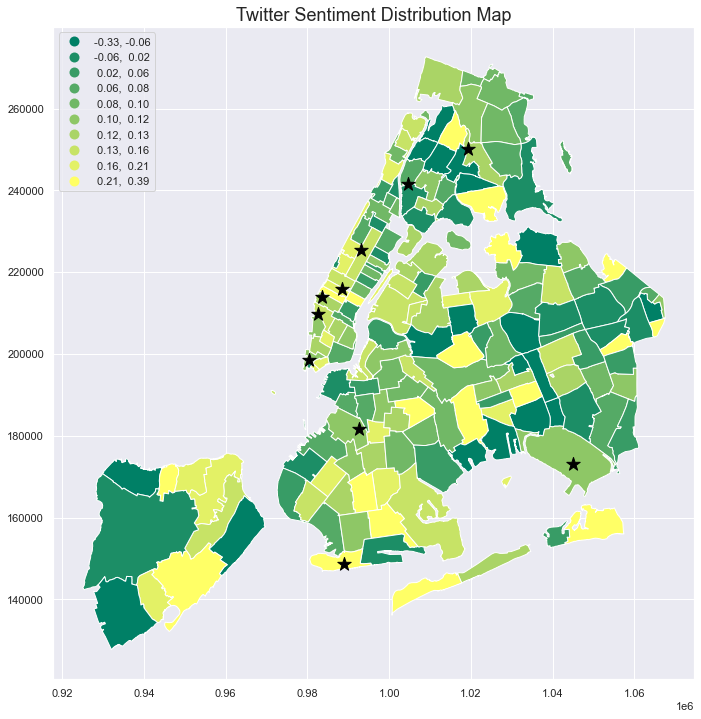

In [63]:
# visualize the spatial distribution of tweet sentiment score
fig, ax = plt.subplots(figsize=(12,12))
ax.set_aspect('equal')

happy_zip.plot(column='final_score',cmap='summer', k=10, scheme='Quantiles', legend=True,ax=ax,legend_kwds={'loc': 'upper left'})
# plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
poi_g.plot(ax=ax, marker='*', color = 'black',markersize=200, legend=True)

plt.title("Twitter Sentiment Distribution Map", fontsize = 18)
plt.savefig("Twitter_Sentiment_Map.png", transparent = True)
# plt.show();